In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
from copy import copy
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV


In [2]:
master_df = pd.read_csv('../data/us_kickstarter.zip')

In [3]:
len(master_df['sub_category'].unique())

146

In [4]:
from copy import copy
df = copy(master_df)
df = df.drop_duplicates('project_id', keep='first')

In [5]:
## remove live projects
df = df[df['state'] != 'live']

In [6]:
### successful, not successful
df['state'] = np.where(df['state'] == 'successful', 1, 0)

In [7]:
cols_to_select = ['category', 'category_parent_id', 'days_to_deadline', 'staff_pick', \
                 'location_type', 'location_state', 'location_id', 'goal', \
                  'launched_weekday', 'description_length', 'is_weekend_launch', \
                 'launched_week', 'launched_month']


In [8]:
target = df['state']
df = df[cols_to_select]

In [9]:
def set_dummies(df):
    
    # categories
    categories = pd.get_dummies(df['category'], prefix='_')
    df = df.join(categories)
    df.drop('category', axis=1)
    
    # state
    states = pd.get_dummies(df['location_state'], prefix='_')
    df = df.join(states)
    df.drop('location_state', axis = 1)
    
    # type
    types = pd.get_dummies(df['location_type'], prefix='_')
    df = df.join(types)
    df.drop('location_type', axis=1)
    
    return df

In [10]:
df = set_dummies(df)

In [11]:
df.drop('category', axis=1, inplace=True)

df.drop('location_type', axis=1, inplace=True)

df.drop('location_state', axis=1, inplace=True)

In [12]:
df['category_parent_id'] = df['category_parent_id'].fillna(0)

In [13]:
def train_model(Xtrain, ytrain):
    rf = RandomForestClassifier(n_estimators = 10, max_depth = 10 )
    rf.fit(Xtrain, ytrain)
    
    score = rf.score(Xtrain, ytrain)
    
    return rf, score
    

In [14]:
def lr_train(Xtrain, ytrain):
    lr = LogisticRegression()
    lr.fit(Xtrain, ytrain)
    
    score = lr.score(Xtrain, ytrain)
    
    return lr, score

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df, target, test_size=0.3, random_state=42)

In [16]:
to_scale = ['goal', 'description_length', 'days_to_deadline']

In [17]:
scaler = StandardScaler()

In [18]:
Xtrain.loc[:,to_scale] = scaler.fit_transform(Xtrain[to_scale])

C:\Users\sahil\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size = 0.4, random_state=42)

In [20]:
Xval.loc[:, to_scale] = scaler.transform(Xval[to_scale])

In [21]:
Xtest.loc[:, to_scale] = scaler.transform(Xtest[to_scale])

# Logistic Regression

In [22]:
lr = lr_train(Xtrain, ytrain)

C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
lr[0]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
lr[1]

0.5552605636958372

In [25]:
lr[0].score(Xval, yval)

0.5549359588742703

In [26]:
from sklearn.metrics import classification_report

# Print Classification Report

In [27]:
print (classification_report(ytest, lr[0].predict(Xtest)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6801
           1       0.56      1.00      0.71      8503

    accuracy                           0.56     15304
   macro avg       0.28      0.50      0.36     15304
weighted avg       0.31      0.56      0.40     15304



C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Apply Bagging Algorithm

In [28]:
bagging = BaggingClassifier()

bagging.fit(Xtrain, ytrain)

bagging.score(Xtrain, ytrain)

0.9845297306985706

In [29]:
bagging.score(Xval, yval)

0.7036682059771717

In [30]:
# remove one column and check the performance of the model

def one_col_sensitivity_analysis():
    score_list = {}

    for col in cols_to_select:
        cols_copy = copy(cols_to_select)
        cols_copy.remove(col)
        df_copy = df[cols_copy]
        Xtrain, Xtest, ytrain, ytest = train_test_split(df, target, test_size=0.3, random_state=42)
        scaler = StandardScaler()
        Xtrain = scaler.fit_transform(Xtrain)
        
        
        _, score_list[col] = train_model(Xtrain, ytrain)
        
    return score_list
    

In [31]:
rf, score = train_model(Xtrain, ytrain)

In [32]:
score

0.7259488282475243

In [33]:
Xval[to_scale] = scaler.transform(Xval[to_scale])

In [34]:
rf.score(Xval, yval)

0.5866079986059075

In [35]:
print (classification_report(ytest, rf.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.75      0.57      0.65      6801
           1       0.71      0.85      0.77      8503

    accuracy                           0.72     15304
   macro avg       0.73      0.71      0.71     15304
weighted avg       0.73      0.72      0.72     15304



In [36]:
confusion_matrix(ytest, rf.predict(Xtest))

array([[3874, 2927],
       [1303, 7200]], dtype=int64)

In [37]:
from sklearn.metrics import roc_curve, auc

In [38]:
(fpr, tpr, threshold) = roc_curve(ytest, rf.predict(Xtest), pos_label=2)

C:\Users\sahil\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


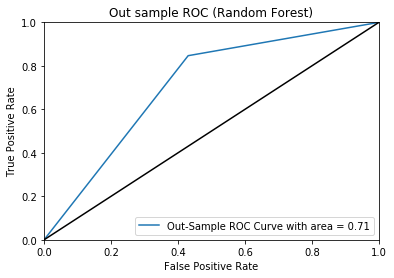

In [39]:
(fpr, tpr, thresholds) = roc_curve(ytest,rf.predict(Xtest))

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Out sample ROC (Random Forest)')
plt.legend(loc="lower right")
plt.show()

In [40]:
area

0.7081910407326938

In [41]:
rf2, score = train_model(Xtrain[pd.Series(rf.feature_importances_, index=Xtrain.columns).\
                                sort_values(ascending=False)[:15].index], ytrain)

In [42]:
score

0.7209190303356185

In [43]:
rf2.score(Xval[pd.Series(rf.feature_importances_, index=Xtrain.columns).\
                                sort_values(ascending=False)[:15].index], yval)

0.6276901629345648

In [44]:
features = pd.Series(rf.feature_importances_, index = list(map(lambda x: x.replace('_', ''),\
                                                               Xtrain.columns))).sort_values(ascending=False)[:15]

In [45]:
def plot_imp_features(feature_imp):
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features")
    plt.show()

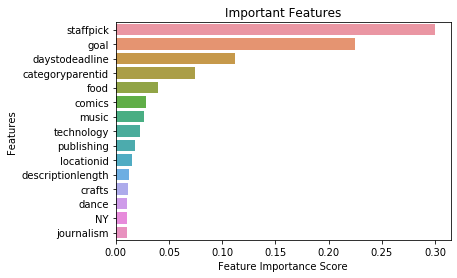

In [46]:
plot_imp_features(features)

In [47]:
live = pd.read_csv('../data/us_kickstarter.zip')
live = live[live['state'] == 'live']

In [48]:
sample = live[live['id'] == 310704614.0]

In [49]:
testing = sample[cols_to_select]

In [50]:
testing = set_dummies(testing)

In [51]:
testing.drop(['category', 'location_type', 'location_state'], axis=1, inplace=True)

In [52]:
columns = Xtrain.columns

In [53]:
columns = list(set(columns) - set(testing.columns))

In [54]:
testing.loc[:, columns[0]] = 0

In [55]:
testing.iloc[0][columns[0]]

0.0

In [56]:
for col in columns:
    testing.loc[:, col] = 0

In [57]:
len(testing.columns)

83

In [58]:
testing = testing.dropna()

In [59]:
rf.predict(testing)

array([0])

In [60]:
rf.predict_proba(testing)

array([[0.64351036, 0.35648964]])

## Check the Model with Suggested Changes

In [61]:
testing.iloc[0]['launched_weekday'] = 2
testing.iloc[0]['is_weekend_launch'] = False
testing.iloc[0]['days_to_deadline'] = 30

C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'description_length'] = 145

In [63]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'goal'] = 1400

In [64]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'days_to_deadline'] = 30

In [65]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'launched_weekday'] = 1

In [66]:
testing.loc[testing['category_parent_id'] == testing.iloc[0]['category_parent_id'], 'is_weekend_launch'] = False

In [67]:
rf.predict(testing)

array([0])

In [68]:
rf.predict_proba(testing)

array([[0.78511571, 0.21488429]])

In [69]:
rf.predict(testing)

array([0])

In [70]:
success = pd.DataFrame(Xtest[ytest==1].iloc[5]).T

In [71]:
rf.predict(success)

array([1])

In [72]:
rf.predict_proba(success)

array([[0.09011836, 0.90988164]])

In [73]:
success.loc[6961, 'description_length'] = 140

In [74]:
success.dropna(inplace=True)

In [75]:
rf.predict(success)

array([1])

In [76]:
rf.predict_proba(success)

array([[0.09011836, 0.90988164]])

In [77]:
pd.Series(rf.feature_importances_, index=df.columns).sort_values(ascending=False)

staff_pick            0.299779
goal                  0.225229
days_to_deadline      0.111731
category_parent_id    0.074292
__food                0.039587
__comics              0.028600
__music               0.026241
__technology          0.022708
__publishing          0.018409
location_id           0.015566
description_length    0.012276
__crafts              0.011454
__dance               0.010975
__NY                  0.010192
__journalism          0.010122
__CA                  0.009422
launched_week         0.008750
__photography         0.008622
__FL                  0.008443
launched_month        0.007033
launched_weekday      0.006238
__County              0.003534
__film & video        0.003379
is_weekend_launch     0.002029
__MA                  0.001946
__Town                0.001881
__TN                  0.001633
__TX                  0.001490
__OR                  0.001228
__art                 0.001160
                        ...   
__Island              0.000303
__RI    

In [78]:
features = pd.Series(rf.feature_importances_, index=df.columns).sort_values(ascending=False)

In [79]:
rf2, score2 = train_model(Xtrain[features[features > 0.05].index], ytrain)

In [80]:
rf2.score(Xval[features[features > 0.05].index], yval)

0.5549359588742703